# 泰坦尼克号数据分析

## 1. 介绍

泰坦尼克号数据：包括泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。你可以右键点击 [该链接](https://raw.githubusercontent.com/ShiChJ/DAND-Basic-Materials/master/P2/Project_Files/titanic-data.csv) 选择“另存为”下载。你也可以在 [Kaggle](https://www.kaggle.com/c/titanic/data) 网站上查看这个数据集的详细描述。这个数据集就是来自 Kaggle。


## 2. 设置报告

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numbers import Number
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 3 读取数据

In [24]:
titanic_df = pd.read_csv('titanic-data.csv')

## 4 处理冗余数据

### 4.1 初步分析原始数据


In [25]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


原始数据在Age,Cabin,Embarked这三个值中有缺失的数据,下面对Age Embarked数据进行处理,并删除不必要的列

### 4.2 缺失的年龄数据处理

In [26]:
missing_ages = titanic_df[titanic_df['Age'].isnull()]

mean_ages = titanic_df.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(row):
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'], row['Pclass']]
    else:
        return row['Age']
    
titanic_df['Age'] = titanic_df.apply(remove_na_ages, axis=1)

### 4.3 缺失的出发港数据处理

In [27]:
missing_ports = titanic_df[titanic_df['Embarked'].isnull()]
missing_ports

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

In [28]:
titanic_df[titanic_df['Embarked'].notnull() & ((titanic_df['Ticket'] == '113572') | (titanic_df['Cabin'] == 'B28'))]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []

In [29]:
titanic_df['Embarked'].fillna('S', inplace=True)

### 4.4 删除不需要的列

In [30]:
titanic_df = titanic_df.drop(['Cabin','Name','Ticket'], axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


### 4.5 值转换

Survived->Boolean (1=True 0=False)

Embarked -> C=Cherbourg Q=Queestown S=Southampton


In [41]:
def map_data(df):
    survived_map = {0:False, 1:True}
    df['SurvivedLabel'] =df['Survived'].map(survived_map)
    
    sex_map = {'male':1, 'female':2}
    df['SexLabel'] = df['Sex'].map(sex_map)
    
    port_map = {'C':'Cherbourg', 'Q':'Queestown','S':'Southampton'}
    df['Embarked']=df['Embarked'].map(port_map)
    
    df['FamilySize'] =df['SibSp'] + df['Parch']
    
    return df

titanic_df = map_data(titanic_df)
titanic_df.head(6)

PassengerId  Survived  Pclass     Sex        Age  SibSp  Parch     Fare  \
0            1         0       3    male  22.000000      1      0   7.2500   
1            2         1       1  female  38.000000      1      0  71.2833   
2            3         1       3  female  26.000000      0      0   7.9250   
3            4         1       1  female  35.000000      1      0  53.1000   
4            5         0       3    male  35.000000      0      0   8.0500   
5            6         0       3    male  26.507589      0      0   8.4583   

  Embarked  SurvivedLabel  FamilySize age_group  SexLabel  
0      NaN          False           1     20-29         1  
1      NaN           True           1     30-39         2  
2      NaN           True           0     20-29         2  
3      NaN           True           1     30-39         2  
4      NaN          False           0     30-39         1  
5      NaN          False           0     20-29         1

对年龄数据进行分组

In [32]:
age_labels = ['0-9','10-19', '20-29','30-39','40-49','50-59','60-69','70-79']
titanic_df['age_group'] = pd.cut(titanic_df.Age, range(0,81,10), right=False, labels=age_labels)

titanic_df.head(6)

PassengerId  Survived  Pclass     Sex        Age  SibSp  Parch     Fare  \
0            1         0       3    male  22.000000      1      0   7.2500   
1            2         1       1  female  38.000000      1      0  71.2833   
2            3         1       3  female  26.000000      0      0   7.9250   
3            4         1       1  female  35.000000      1      0  53.1000   
4            5         0       3    male  35.000000      0      0   8.0500   
5            6         0       3    male  26.507589      0      0   8.4583   

      Embarked  SurvivedLabel  FamilySize age_group  
0  Southampton          False           1     20-29  
1    Cherbourg           True           1     30-39  
2  Southampton           True           0     20-29  
3  Southampton           True           1     30-39  
4  Southampton          False           0     30-39  
5    Queestown          False           0     20-29

In [33]:
titanic_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.318643    0.523008   
std     257.353842    0.486592    0.836071   13.281103    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.750000    0.000000   
50%     446.000000    0.000000    3.000000   26.507589    0.000000   
75%     668.500000    1.000000    3.000000   36.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  FamilySize  
count  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    0.904602  
std      0.806057   49.693429    1.613459  
min      0.000000    0.000000    0.000000  
25%      0.000000    7.910400    0.000000  
50%      0.000000   14.454200    0.000000  
75%      0.000000   31.000000    1.000000  
max      6.000000  512.329200   10.000000

## 分析数据

从三个方面分析

第一个性别

第二个舱室级别

第三个年龄段


Text(0.5,1,'FamilySize and survived')

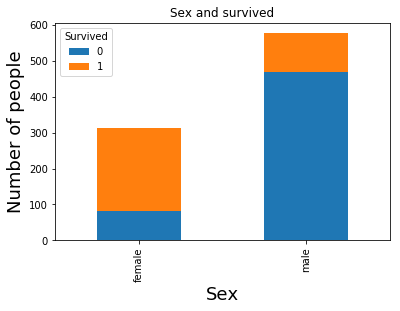

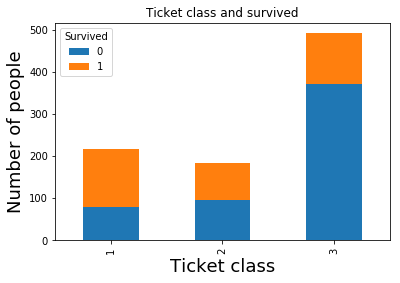

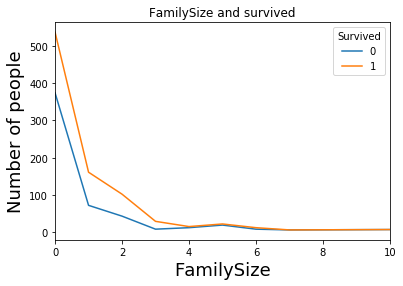

In [34]:
from matplotlib import pyplot as plt

gp = titanic_df.groupby(["Sex","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Sex',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Sex and survived')

gp = titanic_df.groupby(["Pclass","Survived"])["Survived"].count().unstack().plot(kind="bar",stacked="True")
plt.xlabel('Ticket class',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Ticket class and survived')

gp = titanic_df.groupby(["FamilySize","Survived"])["Survived"].count().unstack().plot(kind="line",stacked="True")
plt.xlabel('FamilySize',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('FamilySize and survived')

根据上图分析结果

1. 女性的幸存率高于男性

2. 船票的级别越高生存率越高（1st class代表高等舱 ）

3. 家庭成员越少的生存几率越高

In [49]:
def correlation(x, y):
    std_x = (x - x.mean())/x.std(ddof=0)
    std_y = (y - x.mean())/y.std(ddof=0)
    
    return (std_x*std_y).mean()

print('性别相关性：%s'%correlation(titanic_df['Survived'],titanic_df['SexLabel']))

print('船票级别相关性：%s'%correlation(titanic_df['Survived'],titanic_df['Pclass']))

#print(correlation(titanic_df['Survived'],titanic_df['Age']))

print('家庭成员相关性：%s'%correlation(titanic_df['Survived'],titanic_df['FamilySize']))

性别相关性：0.543351380657757
船票级别相关性：-0.3384810359610135
家庭成员相关性：0.01663898928274497


In [ ]:
说明性别有正向相关性，女性高于男性（这里男性是1女性是2）
船票级别有相关性，程负相关，级别越低，幸存率越低
家庭成员数相关性很小